In [2]:
# https://www.tensorflow.org/tutorials/reinforcement_learning/actor_critic

In [1]:
import collections

import gym
import haiku as hk
import matplotlib.pyplot as plt
import optax
from jax import jit, lax, vmap, value_and_grad, partial
import jax.nn as nn
import jax.numpy as np
import jax.random as random
from jax.tree_util import tree_map
import tqdm

In [2]:
env = gym.make("CartPole-v0")
gamma = .99
num_actions = env.action_space.n  # 2
num_hidden_units = 128
max_steps = 200
optimizer = optax.adam(learning_rate=.01)
eps = np.finfo(np.float32).eps.item()

In [3]:
def net_present_value(rate, values):
    def step(total, value):
        total = value + rate * total
        return total, total
    _, discounted_values = lax.scan(step, init=0, xs=values, reverse=True)
    return discounted_values

In [4]:
def get_values(rewards):
    values = net_present_value(gamma, rewards)
    return nn.normalize(values, epsilon=eps)

In [5]:
def env_init(rng):
    seed = random.randint(r, shape=(), minval=0, maxval=np.iinfo(np.int32).max)
    env.seed(int(seed))
    return np.array(env.reset())

In [6]:
def env_step(action):
    state, reward, done, _ = env.step(int(action))
    return (np.array(state), np.array(reward), np.array(done))

In [7]:
@hk.without_apply_rng
@hk.transform
def model(x):
    x = hk.Linear(num_hidden_units, name='common')(x)
    x = nn.relu(x)
    actor = hk.Linear(2, name='actor')(x)
    critic = hk.Linear(1, name='critic')(x)
    return actor, critic

In [8]:
@jit
def sample_policy(rng, model_state, state):
    policy, _ = model.apply(model_state, state)
    rng, r = random.split(rng)
    return random.categorical(r, policy)

In [32]:
def run_episode(rng, model_state):
    def generate_episode(rng, state):
        for i in range(max_steps):
            rng, r = random.split(rng)
            action = sample_policy(r, model_state, state)
            next_state, reward, done = env_step(action)
            yield (state, action, reward)
            state = next_state
            if done:
                break

                
    rng, r = random.split(rng)
    initial_state = env_init(r)
    episodes = generate_episode(rng, initial_state)
    return tuple(map(np.array, zip(*episodes)))

In [33]:
def huber_loss(yp, y, delta=1.):
    residual = np.abs(y - yp)
    return np.where(residual < delta, .5 * residual ** 2, residual - .5)

In [40]:
@jit
def compute_loss(model_state, state, action, value):
    policy_logits, predicted_value = model.apply(model_state, state)
    advantage = value - predicted_value
    policy_probs = nn.softmax(policy_logits)
    action_prob = policy_probs[action]
    action_log_prob = np.log(action_prob)
    actor_loss = -action_log_prob * advantage
    critic_loss = huber_loss(predicted_value, value)
    return actor_loss + critic_loss

In [41]:
@value_and_grad
def compute_loss_and_grads(model_state, states, actions, values):
    losses = vmap(partial(compute_loss, model_state))(states, actions, values)
    return np.sum(losses)

In [42]:
def train_step(episode, model_state, opt_state):
    states, actions, rewards = episode
    values = get_values(rewards)
    loss_value, loss_grads = compute_loss_and_grads(model_state, states, actions, values)
    model_updates, opt_state = optimizer.update(loss_grads, opt_state, model_state)
    model_state = optax.apply_updates(model_state, model_updates)
    episode_reward = np.sum(rewards)
    return episode_reward, loss_value, model_state, opt_state

In [43]:
rng = random.PRNGKey(42)
rng, r = random.split(rng)
model_state = model.init(r, env_init(r))
opt_state = optimizer.init(model_state)

In [44]:
max_episodes = 500
max_steps_per_episode = 200

items = []
with tqdm.trange(max_episodes) as t:
    for i in t:
        rng, r = random.split(rng)
        episode = run_episode(r, model_state)
        rng, r = random.split(rng)
        episode_reward, loss_value, model_state, opt_state = train_step(episode, model_state, opt_state)
        episode_reward.block_until_ready()
        items.append((episode_reward, loss_value))

100%|█████████████████████████████████████████| 500/500 [01:56<00:00,  4.28it/s]


In [46]:
episode_rewards, loss_values = tuple(map(np.array, zip(*items)))

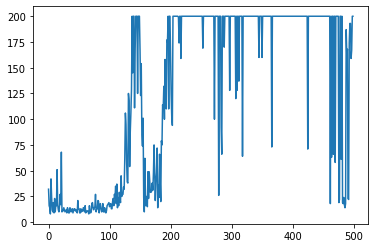

In [47]:
plt.plot(episode_rewards)

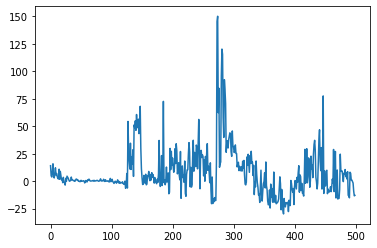

In [48]:
plt.plot(loss_values)